In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, Lasso

import cvxpy as cp

from sklearn.model_selection import GridSearchCV, KFold

plt.rcParams.update({'font.size': 16})

# local modules
import hyperparam

In [28]:
df = pd.read_pickle('./data/IHDP.zip')

Y = np.array(df["y_factual"])
T = np.array(df["treatment"])
X = np.array(df[df.columns[5:]])

In [29]:
Xp = X[T==0]
Xq = X[T==1]

yp = Y[T==0]

Xpc = Xp - Xp.mean(axis=0)
ypc = yp - yp.mean()

In [30]:
n = Xpc.shape[0]
d = Xpc.shape[1]

## ridge outcome model w/ cv

In [31]:
ridge_params = {'alpha':np.linspace(1e-10, 50, 1000)}
ridge_cv = GridSearchCV(Ridge(max_iter=1200, fit_intercept=False), param_grid=ridge_params,cv=3).fit(Xpc, ypc)

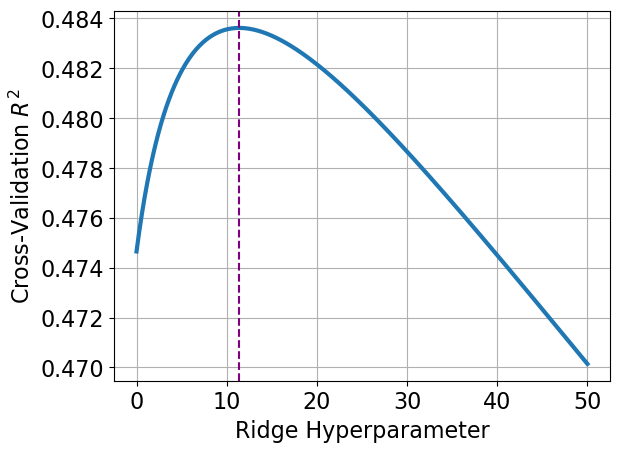

In [32]:
# plt.plot(np.array(ridge_cv.cv_results_['param_alpha']), np.array(ridge_cv.cv_results_['mean_test_score']), linewidth=3)
# plt.axvline(ridge_cv.best_estimator_.alpha, color='purple', linestyle='--')
# plt.xlabel("Ridge Hyperparameter")
# plt.ylabel("Cross-Validation $R^2$")
# plt.ylim([-2.5, 0.5])
# plt.grid()

plt.plot(np.array(ridge_cv.cv_results_['param_alpha']) , np.array(ridge_cv.cv_results_['mean_test_score']), linewidth=3)
plt.axvline(ridge_cv.best_estimator_.alpha, color='purple', linestyle='--')
plt.xlabel("Ridge Hyperparameter")
plt.ylabel("Cross-Validation $R^2$")
#plt.ylim([-2.5, 0.5])
plt.grid()

In [33]:
ridge_cv.best_estimator_.alpha / n

0.018768768768895706

In [34]:
ridge_muhat = ridge_cv.best_estimator_

## lasso outcome model w/ cv

In [35]:
lasso_params = {'alpha':np.linspace(1e-8, 0.2, 500)}
lasso_cv = GridSearchCV(Lasso(max_iter=5000, fit_intercept=False), param_grid=lasso_params,cv=3).fit(Xpc, ypc)

c:\Users\david\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.892e+01, tolerance: 9.679e-02
  model = cd_fast.enet_coordinate_descent(


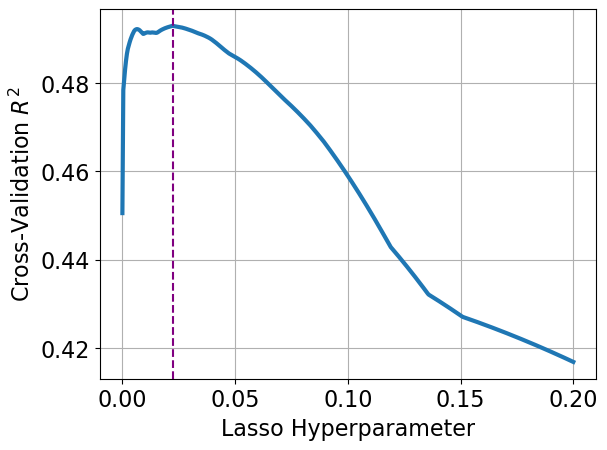

In [36]:
plt.plot(np.array(lasso_cv.cv_results_['param_alpha']) , np.array(lasso_cv.cv_results_['mean_test_score']), linewidth=3)
plt.axvline(lasso_cv.best_estimator_.alpha, color='purple', linestyle='--')
plt.xlabel("Lasso Hyperparameter")
plt.ylabel("Cross-Validation $R^2$")
plt.grid()

In [37]:
lasso_muhat = lasso_cv.best_estimator_

In [38]:
Xqc = (Xq - Xp.mean(axis=0))
Xqb = Xq.mean(axis=0)
Xqcb = Xqc.mean(axis=0)

In [39]:
deltas = np.linspace(0,0.5,1000)
imbals = hyperparam.cross_val_bal_solver(Xqcb, Xp, repeats=1, seed=6401433, plot=True, plot_deltas=deltas)

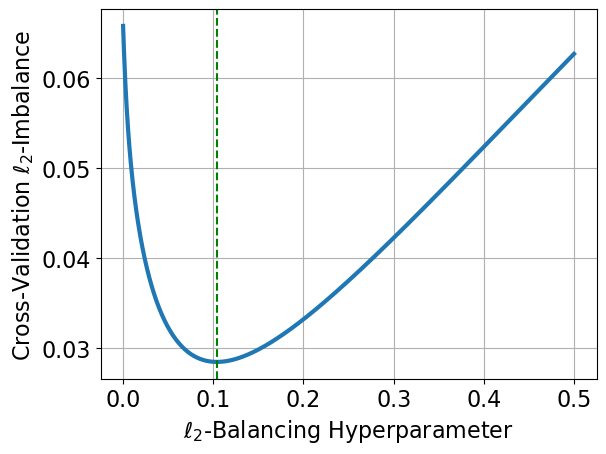

In [40]:
plt.plot(deltas, imbals, linewidth=3)

ridge_bal_cv = deltas[np.argmin(imbals)]

plt.axvline(ridge_bal_cv, color='green', linestyle='--')
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation $\ell_2$-Imbalance")
#plt.ylim([0,100])
plt.grid()

In [41]:
auto_losses = hyperparam.cross_val_autodml_solver(Xqcb, Xp, repeats=1, plot=True, seed=1, plot_deltas=deltas)

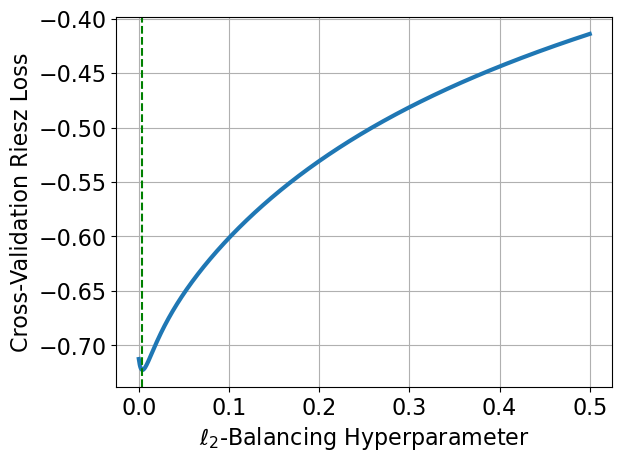

In [42]:
ridge_auto_cv = deltas[np.argmin(auto_losses)]

plt.plot(deltas, auto_losses, linewidth=3)
plt.axvline(ridge_auto_cv, color='green', linestyle='--')
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation Riesz Loss")
plt.grid()

# Check Linf balance

In [43]:
def MDL(delta,Xpc,Xq):

    N=Xpc.shape[0]
    M=Xpc.shape[1]

    rho = cp.Variable(M)

    w = Xpc@rho

    prob = cp.Problem(cp.Minimize( cp.sum_squares(w)/N - 2*rho@Xq + delta*cp.norm(rho,1) ))
    
    optimal_value = prob.solve()

    #optimal_value = prob.solve(solver='ECOS', max_iters=5000)
    #print("t=",t.value)
    #print("x=",x.value)
    #print("val=",optimal_value)
    return(rho.value)

In [52]:
deltas = np.linspace(0,0.1,100)
# deltas = np.linspace(0,0.1,300)

ks = 5
kf = KFold(n_splits=ks, shuffle=True, random_state=None) 
all_losses = []
all_thetas = []
all_imbals = []
for i, (train_index, test_index) in enumerate(kf.split(Xp)):
    trainMean = Xp[train_index, :].mean(axis=0)
    Xtrain = Xp[train_index, :] - trainMean
    Xtest = Xp[test_index, :] - trainMean

    nt = Xtrain.shape[0]
    
    thetas = []
    losses = []
    imbals = []
    for delta in deltas:
        theta = MDL(delta, Xtrain, Xqcb)

        theta[np.abs(theta) < 1e-10] = 0

        loss = hyperparam.autodml_loss(theta, Xtest, Xqcb)
        imbal = hyperparam.calc_imbal(theta, Xtest, Xqcb)
        thetas.append( theta )
        losses.append(loss)
        imbals.append(imbal)

    all_losses.append(losses)
    all_thetas.append(thetas)
    all_imbals.append(imbals)

cv_dels = deltas[np.argmin(np.array(all_losses).mean(axis=0))] 
bal_dels = deltas[np.argmin(np.array(all_imbals).mean(axis=0))] 

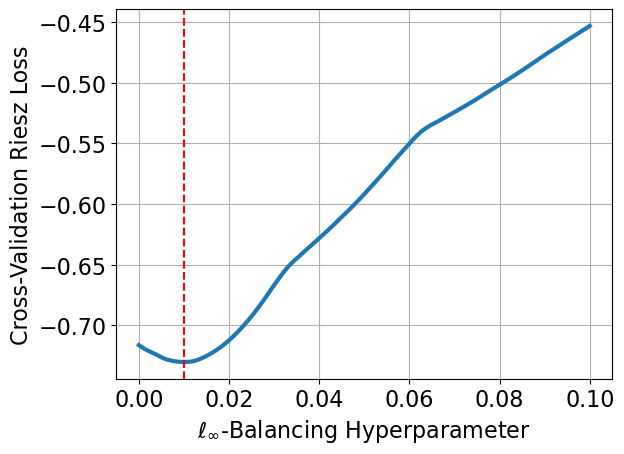

In [53]:
avg_losses = np.array(all_losses).mean(axis=0)

plt.plot(deltas, avg_losses, linewidth=3)

lasso_auto_cv = deltas[np.argmin(avg_losses)]

plt.axvline(lasso_auto_cv, color='red', linestyle='--')
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation Riesz Loss")
plt.grid()

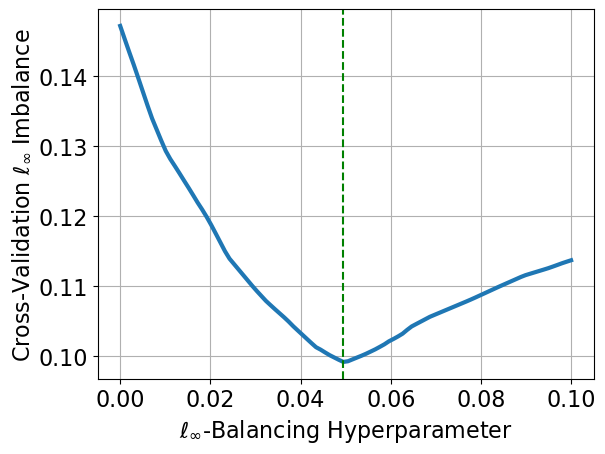

In [54]:
avg_imbals = np.array(all_imbals).mean(axis=0)

plt.plot(deltas, avg_imbals, linewidth=3)

lasso_bal_cv = deltas[np.argmin(avg_imbals)]

plt.axvline(lasso_bal_cv, color='green', linestyle='--')
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Cross-Validation $\ell_\infty$ Imbalance")

plt.grid()

### plot sweep of final augmented point estimates

In [55]:
betahat = ridge_muhat.coef_
deltas = np.linspace(0, 0.5, 300)
aug_points = []
for delta in deltas:
    rhohat = np.linalg.pinv(Xpc.T@Xpc/n + delta*np.eye(Xpc.shape[1])) @ Xqcb
    what = Xpc@rhohat/n

    aug = Xqcb@betahat + what@(ypc - Xpc@betahat)
    aug_points.append(aug)

In [56]:
betaols = np.linalg.pinv(Xpc.T@Xpc)@Xpc.T@ypc

Text(0, 0.5, 'Augmented Point Estimate')

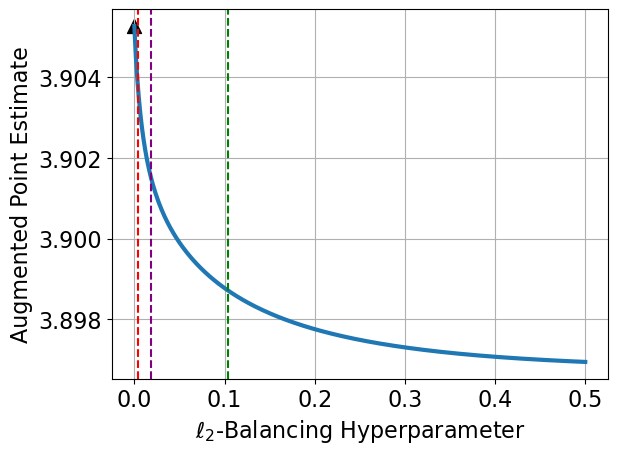

In [58]:
plt.plot(deltas,Y[T==1].mean() - (yp.mean()+np.array(aug_points)), linewidth=3)
plt.scatter(0,Y[T==1].mean() - (yp.mean()+Xqcb@betaols),color='black', marker='^', s=100)
#plt.axvline(mean_opt_delta2, color='blue', linestyle='--')
plt.axvline(ridge_muhat.alpha/n, color='purple', linestyle='--')
plt.axvline(ridge_bal_cv, color='green', linestyle='--')
plt.axvline(ridge_auto_cv, color='red', linestyle='--')

plt.grid()
plt.xlabel("$\ell_2$-Balancing Hyperparameter")
plt.ylabel("Augmented Point Estimate")

In [59]:
betahat = lasso_muhat.coef_
deltas = np.linspace(0,0.5,300)
aug_points = []
for delta in deltas:

    if delta == 0:
        aug_points.append(Xqcb@betaols)
        continue

    theta = MDL(delta, Xpc, Xqcb)

    theta[np.abs(theta) < 1e-10] = 0

    what = Xpc@theta/n

    aug = Xqcb@betahat + what@(ypc - Xpc@betahat)
    aug_points.append(aug)

In [60]:
lasso_bal_cv

0.049494949494949494

Text(0, 0.5, 'Augmented Point Estimate')

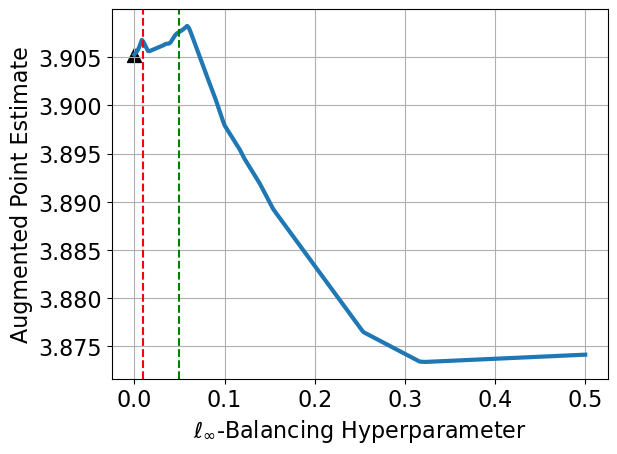

In [62]:
plt.plot(deltas,Y[T==1].mean() - (yp.mean()+np.array(aug_points)), linewidth=3)
plt.scatter(0,Y[T==1].mean() - (yp.mean()+Xqcb@betaols),color='black', marker='^', s=100)

plt.axvline(lasso_bal_cv, color='green', linestyle='--')
plt.axvline(lasso_auto_cv, color='red', linestyle='--')

plt.grid()
plt.xlabel("$\ell_\infty$-Balancing Hyperparameter")
plt.ylabel("Augmented Point Estimate")